In [26]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

exp_dir = 'recovery-rl/outputs/swing'

fnames = [os.path.join(run_dir, 'run_stats.pkl') for run_dir in os.listdir(exp_dir)]

test_return_list = []
test_safe_list = []

for fname in fnames:
    with open(osp.join(exp_dir, fname), 'rb') as f:
        data = pickle.load(f)
    test_stats = data['test_stats'][:200] # evaluate 200 times during trainig
    
    # calculate return
    test_returns = []
    for traj_stats in test_stats:
        avg_ret = 0
        for traj_traj in traj_stats:
            rewards = [t['reward'] for t in traj_stat]
            ret = np.sum(rewards)
            avg_ret += ret
        avg_ret /= len(traj_stats)
        test_returns.append(avg_ret)
    test_returns = np.cumsum(test_returns) / np.array(range(1, len(test_returns)+1)) # cumulative mean
    test_return_list.append(test_returns)                    
    
    # calculate safey
    test_safe = [float(len(traj_stats)>=1000) for traj_stats in test_stats]
    test_safe = np.cumsum(test_safe) / np.array(range(1, len(test_safe)+1)) # cumulative mean
    test_safe_list.append(test_safe)

test_return_list = np.array(test_return_list)
test_safe_list = np.array(test_safe_list)


fig, axes = plt.subplots(1, 2, figsize=(20, 8))
# plot return
axes[0].set_title("Return")
xs = np.array(range(len(test_return_list[0])))
axes[0].plot(xs, np.quantile(test_return_list, 0.5, axis=0))
axes[0].fill_between(xs, np.quantile(test_return_list, 0.25, axis=0), np.quantile(test_return_list, 0.75, axis=0), alpha=0.2)
# plot safe
axes[1].set_title("Safety")
xs = np.array(range(len(test_safe_list[0])))
axes[1].plot(xs, np.quantile(test_safe_list, 0.5, axis=0))
axes[1].fill_between(xs, np.quantile(test_safe_list, 0.25, axis=0), np.quantile(test_safe_list, 0.75, axis=0), alpha=0.2)

                    

TypeError: list indices must be integers or slices, not str

# 2 Test
## 2.1 Load Test Result

In [789]:
import os
import numpy as np
import json
from collections import defaultdict

task_name = "cartpole_swingup"
label_name = "Adv"
# exp_name = "default"
exp_name = "l2_adv_param-coef1e-4-freq1e3ratio0.1"

base_dir=f"outputs/{task_name}-{exp_name}" # l2norm-coef1e-4"

all_perturbs = [("pole_length", 1.0), ("pole_mass", 0.1), ("joint_damping", 2e-6), ("slider_damping", 5e-4)]


In [790]:
# import os
# import numpy as np
# import json
# from collections import defaultdict

# base_dir="../outputs/robust_mbpo-walker_walk-default"
# perturb_name="thigh_length"
# nomial_value = 0.225
# plot_id = 0
# perturb_name="torso_length"
# nomial_value = 0.3
# plot_id = 1
# perturb_name="joint_damping"
# nomial_value = 0.1
# plot_id = 2
# perturb_name="contact_friction"
# nomial_value = 0.7
# plot_id = 3

# ax_name = f"walker_walk - {perturb_name} - twiced"

## 2.2 Draw plot

In [791]:

import matplotlib.pyplot as plt


def fetch_data(perturb_name):

    ds = defaultdict(list)
    for random_seed in os.listdir(base_dir):

        if random_seed.startswith("."): continue

        test_dir = os.path.join(os.path.join(base_dir, random_seed), "test")

        for file_name in os.listdir(test_dir):
            if perturb_name not in file_name or file_name.startswith("."): continue

            file_path = os.path.join(test_dir, file_name)
            with open(file_path, "r") as rf:
                data = json.load(rf)
            ds[data["perturb_spec"]["start"]].extend(data["episode_rewards"])

    xs = sorted(ds.keys())
    ys = [ds[key] for key in xs]
    return xs, ys


# plot all_perturbs
for plot_id, (perturb_name, nomial_value) in enumerate(all_perturbs):
    # retrieve data
    xs, ys = fetch_data(perturb_name)
    y_min, y_max = 0, 1000
    y_name = "mean return"
    x_name = "parameter value"
    ax_name = f"cartpole_swingup - {perturb_name}"

    # plot plot_id
    ax1 = axes[plot_id]
    ax1.set_title(ax_name, fontsize=20)
    ax1.set_xlabel(x_name, fontsize=20)
    ax1.set_ylabel(y_name, fontsize=20)
    ax1.set_ylim((y_min, y_max))
    # ax1.set_xlim((x_min, x_max))  
    ax1.tick_params(labelsize=16)

    # [0.1, 0.25, 0.5] as a case to evaluate robustness
    y_quantile_l = np.quantile(ys, 0.1, axis=1)
    y_quantile_u = np.quantile(ys, 0.5, axis=1)
    y_median = np.quantile(ys, 0.3, axis=1)

    alpha = 0.2
    ax1.plot(xs, y_median, linewidth=1.5, marker="o", label=label_name)
    ax1.fill_between(xs, y_quantile_l, y_quantile_u, alpha=alpha)

    # scatter for nomial model
    ax1.axvline(x=nomial_value, color="c", linestyle='dashed')
    ax1.legend()


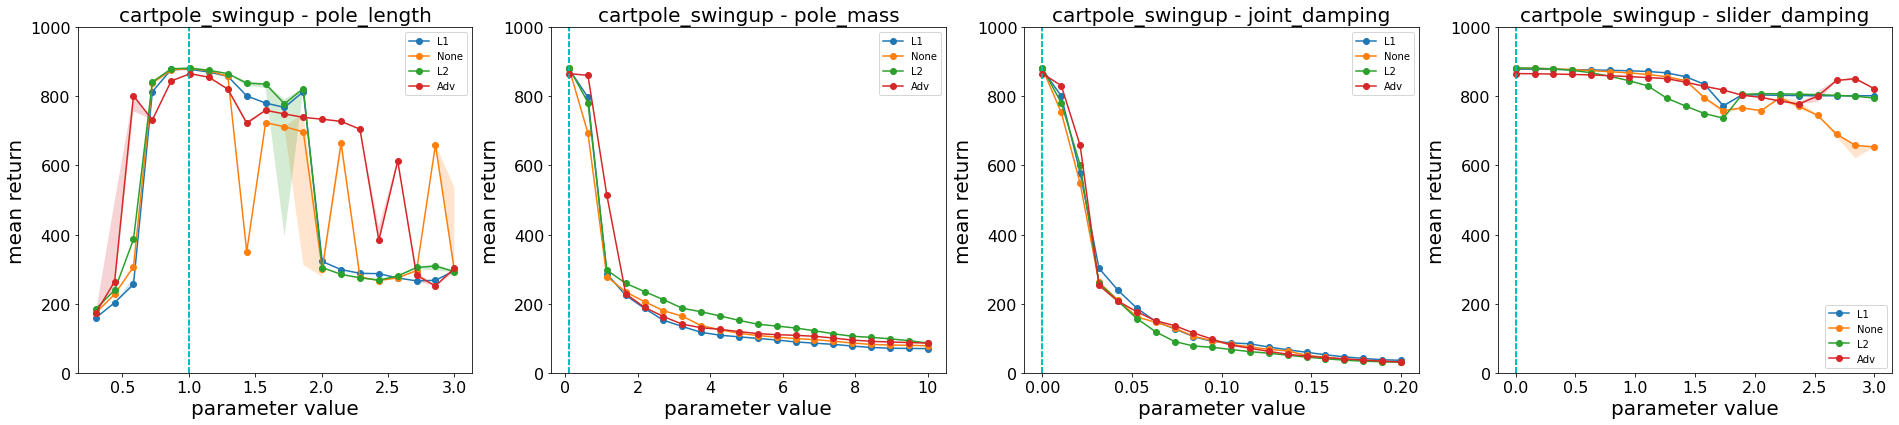

In [792]:
fig

In [793]:
fig.savefig(f"outputs/{task_name}.pdf", dpi=600)

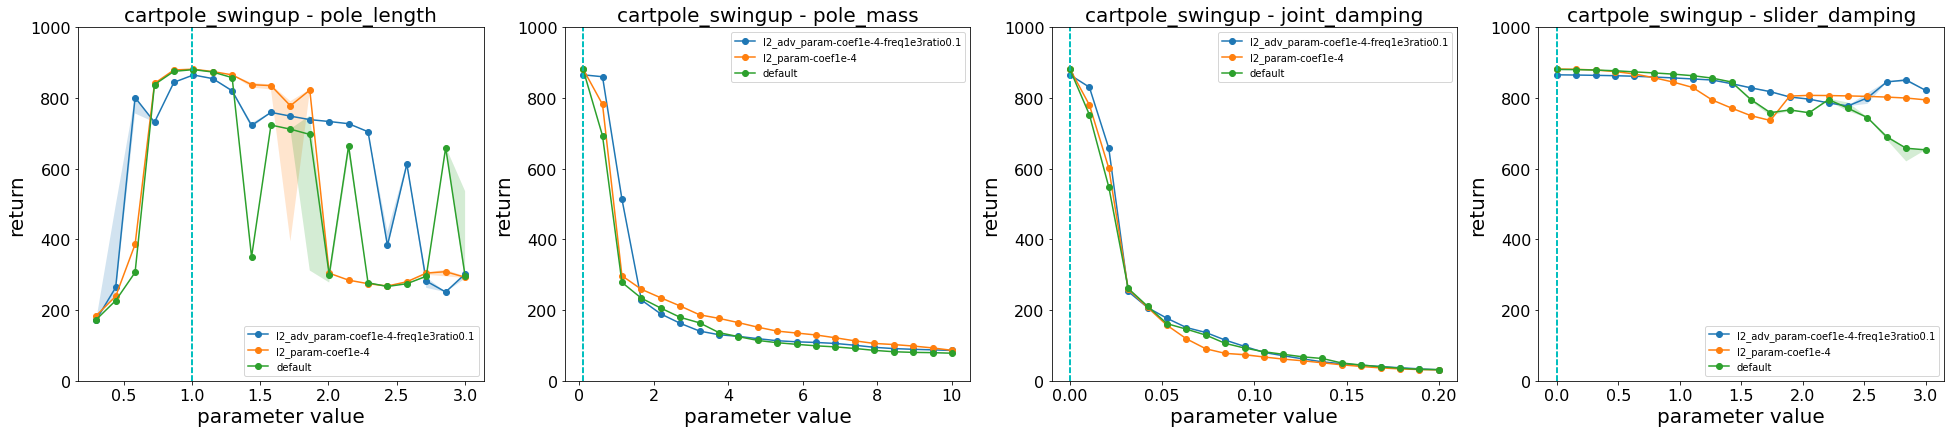

In [580]:
fig

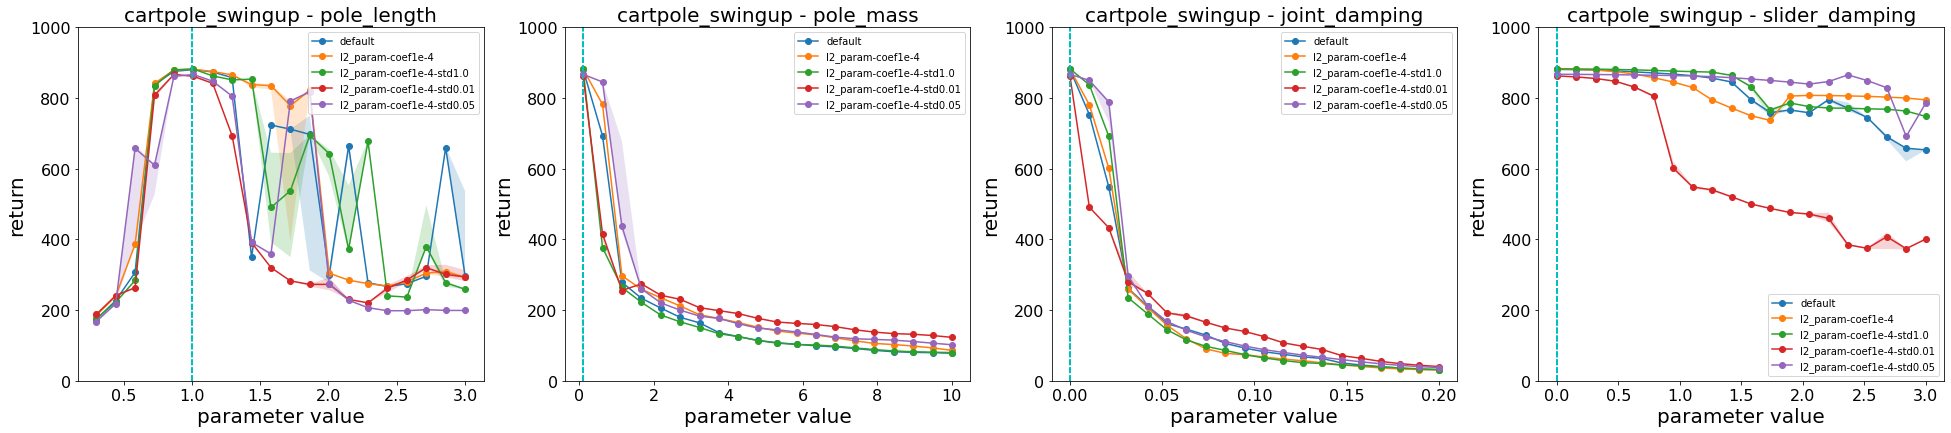

In [604]:
fig

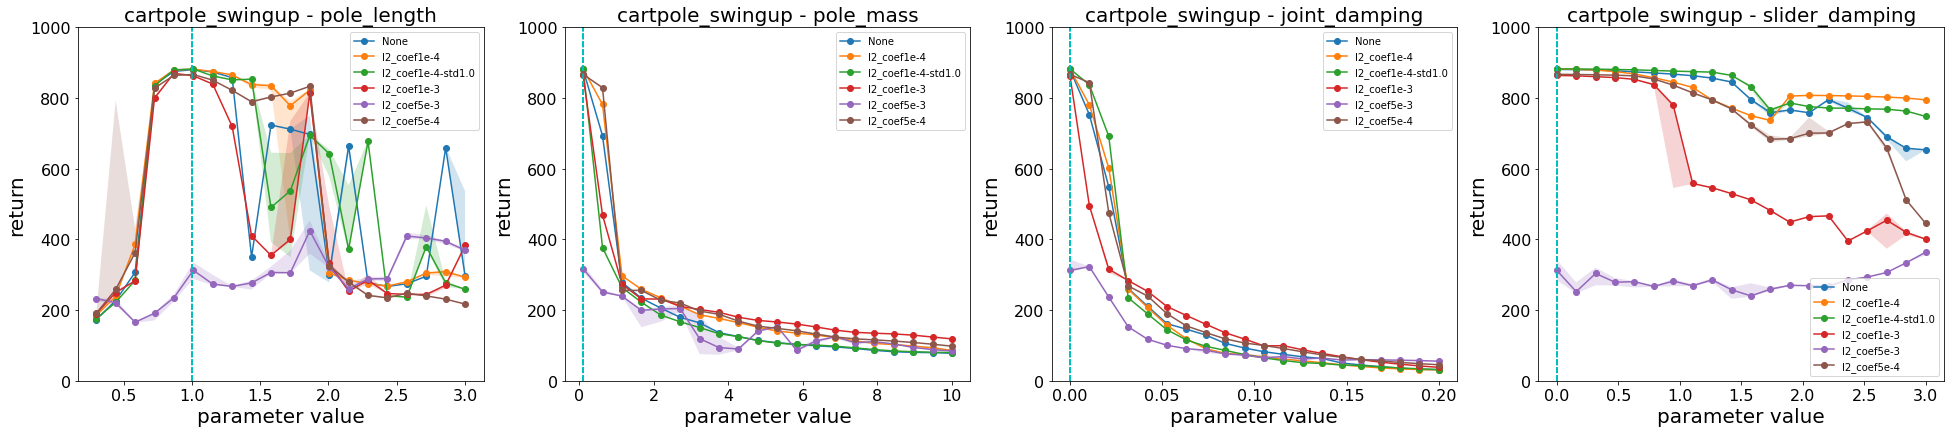

In [538]:
fig

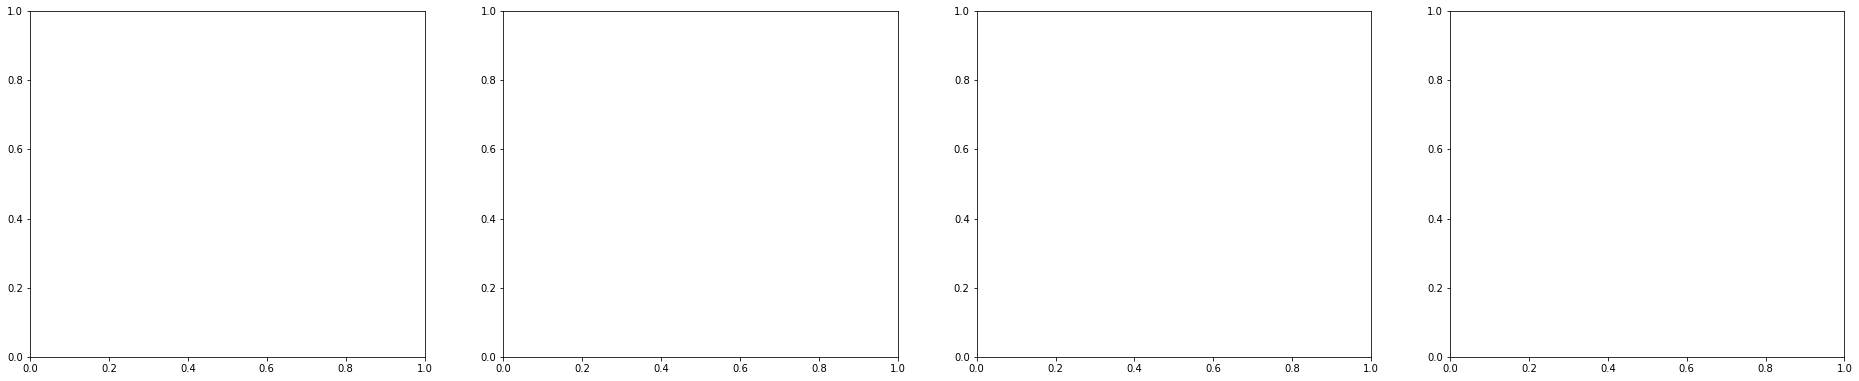

In [778]:
# Run this plot first!
fig, axes = plt.subplots(1, 4, figsize=(28, 6))
fig.subplots_adjust(left=0.05, bottom=0.1, top=0.9, right=0.95)


# 1 Uncertianty Set

In [10]:
import numpy as np
import matplotlib.pyplot as plt
init_value = [1.0, 1.0]
perturb = 0.5

def sample(method="l2"):
    M = 1000
    points = []
    for i in range(M):
        if method == "l2":
            z = np.random.randn(2) 
            z_on_unit_sphere = z / np.linalg.norm(z, ord=2)  
            scale = np.random.uniform(0, 1) ** 0.5 
            z_scaled = z_on_unit_sphere * scale 
            sample_value = init_value + z_scaled * perturb
            
        elif method == "ellipsoid":
            z = np.random.randn(2) 
            z_on_unit_sphere = z / np.linalg.norm(z, ord=2)  
            scale = np.random.uniform(0, 1) ** 0.5 
            z_scaled = z_on_unit_sphere * scale 
            T_matrix = np.array([[perturb, perturb],[0, 2.0*perturb]])
            sample_value = init_value + np.matmul(T_matrix, z_scaled) 
        elif method == "none":
            sample_value = init_value
        elif method == "l+":
            sample_value = [0, 0]
            perturb_val = [2.0 * perturb, perturb]
            for i in range(2):
                sample_value[i] = np.random.uniform(init_value[i]-perturb_val[i], init_value[i]+perturb_val[i])
        points.append(sample_value)
    points = np.stack(points)
    return points

def multivariate_gaussian(mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""
    
    N = 1000
    X = np.linspace(-1, 3, N)
    Y = np.linspace(-1, 3, N)
    X, Y = np.meshgrid(X, Y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    Z = np.exp(-fac / 2) / N
    return X, Y, Z


def draw_plots(true_points, pred_points):
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    fig.subplots_adjust(left=0.14, bottom=0.132, top=0.95, right=0.95)
    
    # plot true uncertainty set
    ax1 = axes[0]
    ax1.set_title("Real Uncertainty Set", fontsize=20)
    # ax1.set_xlabel(xname, fontsize=20)
    # ax1.set_ylabel(yname, fontsize=20)
    ax1.set_ylim((-1, 3))
    ax1.set_xlim((-1, 3))
    ax1.scatter(true_points[:,0], true_points[:,1])
    
    
    # plot fisher information matrix
    X, Y, Z = pred_points
    ax2 = axes[1]
    ax2.set_title("FIM Uncertainty Set", fontsize=20)
    ax2.set_ylim((-1, 3))
    ax2.set_xlim((-1, 3))
    cset = ax2.contourf(X, Y, Z) # , zdir='z', offset=0, cmap=cm.viridis)
    plt.colorbar(cset)
    fig.show()

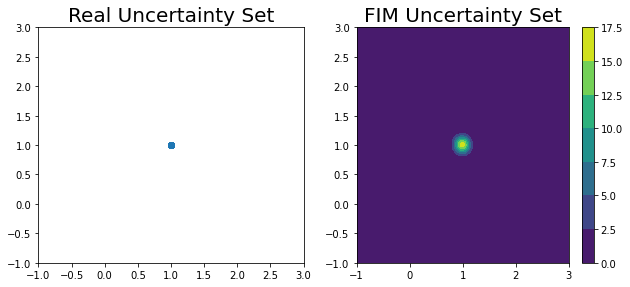

In [20]:

# None Uncertainty Set
Mu = np.array([0.9940, 1.0061])
Sigma = np.array([[0.0101 , -0.0002], [-0.0002,  0.0097]])
fim_points =  multivariate_gaussian(Mu, Sigma)

l2_points = sample(method="none")

draw_plots(l2_points, fim_points)


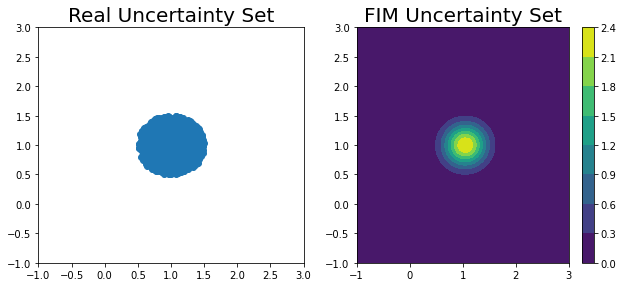

In [12]:

# L2 Uncertainty Set
Mu = np.array([1.0501, 0.9978])
Sigma = np.array([[ 0.0757 , 0.0006], [0.0006,  0.0589]])
fim_points =  multivariate_gaussian(Mu, Sigma)

l2_points = sample(method="l2")

draw_plots(l2_points, fim_points)


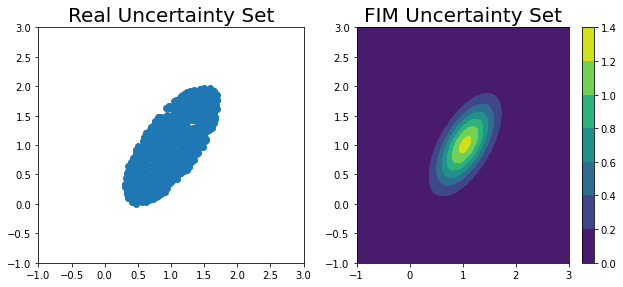

In [13]:

# Ellipsoid Uncertainty Set
Mu = np.array([1.0473, 1.0054])
Sigma = np.array([[ 0.1257 , 0.0986], [0.0986,  0.2052]])
fim_points =  multivariate_gaussian(Mu, Sigma)

l2_points = sample(method="ellipsoid")

draw_plots(l2_points, fim_points)


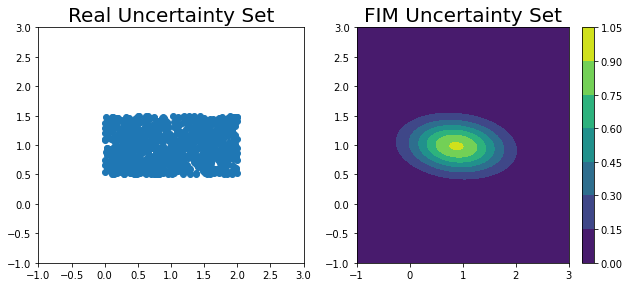

In [14]:

# l+ Uncertainty Set
Mu = np.array([0.8843, 0.9814])
Sigma = np.array([[0.3540, -0.0231], [-0.0231,  0.0861]])
fim_points =  multivariate_gaussian(Mu, Sigma)

linf_points = sample(method="l+")

draw_plots(linf_points, fim_points)


## 2.3 Draw Box 

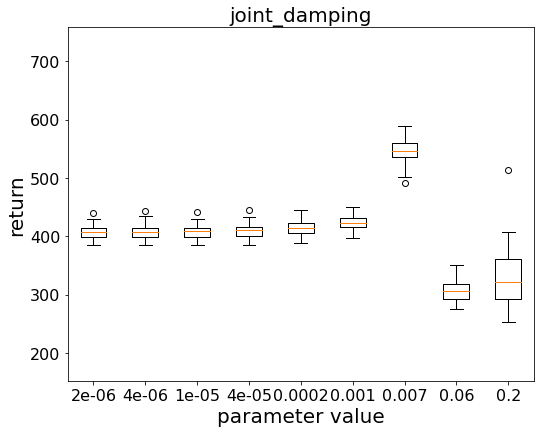

In [14]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig.subplots_adjust(left=0.14, bottom=0.132, top=0.95, right=0.95)

ax1.set_title(ax_name, fontsize=20)
ax1.set_xlabel(x_name, fontsize=20)
ax1.set_ylabel(y_name, fontsize=20)
ax1.set_ylim((y_min, y_max))
ax1.tick_params(labelsize=16)

ax1.boxplot(ys, labels=xs)
plt.show()


# Plot Training Curvers

In [61]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

exp_name = '2.0'
# exp_name = '2.1'

BASE_DIR = './'


# Success/Match
ss, se = 0, 100
x_all, success_all, match_all, bleu_all = [], [], [], []

# hrl
metric = ["success", "match", "bleu"]
for m in metric:
    file_path = os.path.join(BASE_DIR, "hrl_%s"%exp_name,"val_%s.csv"%m)
    with open(file_path, "r") as f:
        curve = pd.read_csv(f)
        value = curve.values
        value = value[ss:se]
        x, y = value[ss:, 1], value[ss:, 2]
        x, y = np.array(x), np.array(y)*100

        if m == "success":
            x_all.append(x)
            success_all.append(y)
        elif m == "match":
            match_all.append(y)
        elif m == "bleu":
            bleu_all.append(y)      
se = len(x_all[-1]) + ss

# larl + word
models_name = ['larl', 'word']

for model_name in models_name:
    file_path = os.path.join(BASE_DIR, "%s_%s"%(model_name,exp_name), "val-rl.tsv")
    with open(file_path, "r") as f:
        lines = f.read().splitlines()
        end = min(se, len(lines))
        lines = lines[ss:end] # tricks
        s, m, x = [], [], []
        for line in lines:
            record = line.split("\t")
            x.append(int(record[0]))
            m.append(float(record[3])*100)
            s.append(float(record[2])*100)
    file_path = os.path.join(BASE_DIR, "%s_%s"%(model_name,exp_name), "val-ppl.tsv")
    with open(file_path, "r") as f:
        lines = f.read().splitlines()
        end = min(se, len(lines))
        lines = lines[ss:end] # tricks
        b = []
        for line in lines:
            record = line.split("\t")
            b.append(float(record[2])*100)           
    x_all.append(np.array(x))
    success_all.append(np.array(s)) # success
    match_all.append(np.array(m))
    bleu_all.append(np.array(b))
 
# human
x_all.append(x_all[-1])
steps = len(x_all[-1])
if exp_name == "2.0":
    success_all.append(np.array([82.7]*steps))
    match_all.append(np.array([91]*steps))
    bleu_all.append(np.array([100]*steps))

else:
    success_all.append(np.array([79.1]*steps))
    match_all.append(np.array([86.3]*steps))
    bleu_all.append(np.array([100]*steps))    

xname = 'Training Episode'
labels = ['HSTDS',
          'LaRL',
          'WE2E',
          'Human'
         ]

# labels.pop(0)

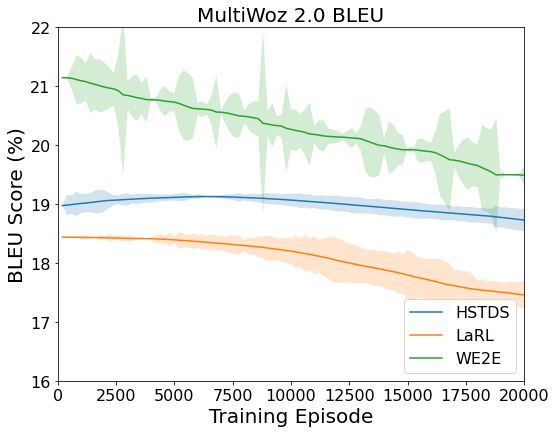

In [64]:
# plot Success
file_name = "multiwoz_%s-success"%exp_name
ax_name = "MultiWoz %s Success"%exp_name
yname = 'Success Rate (%)'
y_min, y_max = 55,90
x_min, x_max = 0, x_all[0][-1]
weight = 0.95
variance = 0.25
alpha = 0.2
y_all = success_all

# plot Match
file_name = "multiwoz_%s-inform"%exp_name
ax_name = "MultiWoz %s Inform"%exp_name
yname = 'Inform Rate (%)'
y_min, y_max = 65, 100
x_min, x_max = 0, x_all[0][-1]
weight = 0.95
variance = 0.25
alpha = 0.2
y_all = match_all


# plot BLEU
file_name = "multiwoz_%s-bleu"%exp_name
ax_name = "MultiWoz %s BLEU"%exp_name
yname = 'BLEU Score (%)'
y_min, y_max = 16, 22
x_min, x_max = 0, x_all[0][-1]
weight = 0.99
variance = 0.2
alpha = 0.2
y_all = bleu_all

# # plot Combined
# ax_name = "MultiWoz %s Combined Score"%exp_name
# yname = 'Combined Score'
# y_min, y_max = 85, 110
# x_min, x_max = 0, x_all[0][-1]
# weight = 0.9
# variance = 0.25
# alpha = 0.2

# smooth function for plots
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig.subplots_adjust(left=0.14, bottom=0.132, top=0.95, right=0.95)

ax1.set_title(ax_name, fontsize=20)
ax1.set_xlabel(xname, fontsize=20)
ax1.set_ylabel(yname, fontsize=20)
ax1.set_ylim((y_min, y_max))
ax1.set_xlim((x_min, x_max))
ax1.tick_params(labelsize=16)


for x, y, label in zip(x_all, y_all, labels):  
    ys = smooth(y, weight)
    if label == "Human":
#         ax1.plot(x, ys, label=label, linewidth=1.5, linestyle="--")
        pass
    else:
        ax1.plot(x, ys, label=label, linewidth=1.5)
    e = (ys - y)*variance
    ax1.fill_between(x, ys-e, ys+e, alpha=alpha)


# for x, s, m, b, label in zip(x_all, success_all, match_all, bleu_all, labels):  
#     y = ( s + m )* 0.5 + b
#     ys = smooth(y, weight)
#     if label == "Human":
#         ax1.plot(x, ys, label=label, linewidth=1.5, linestyle="--")
#     else:
#         ax1.plot(x, ys, label=label, linewidth=1.5)
#     e = (ys - y)*variance
#     ax1.fill_between(x, ys-e, ys+e, alpha=alpha)


ax1.legend(fontsize=16, loc='lower right')

plt.savefig(BASE_DIR + 'outputs/%s.pdf'%file_name, dpi=600)
            
            

In [65]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

# exp_name = '2.0'
exp_name = '2.1'

BASE_DIR = './'


# Success/Match
ss, se = 0, 100
x_all, success_all, match_all, bleu_all = [], [], [], []

# hrl
metric = ["success", "match", "bleu"]
for m in metric:
    file_path = os.path.join(BASE_DIR, "hrl_%s"%exp_name,"val_%s.csv"%m)
    with open(file_path, "r") as f:
        curve = pd.read_csv(f)
        value = curve.values
        value = value[ss:se]
        x, y = value[ss:, 1], value[ss:, 2]
        x, y = np.array(x), np.array(y)*100

        if m == "success":
            x_all.append(x)
            success_all.append(y)
        elif m == "match":
            match_all.append(y)
        elif m == "bleu":
            bleu_all.append(y)      
se = len(x_all[-1]) + ss

# larl + word
models_name = ['larl', 'word']

for model_name in models_name:
    file_path = os.path.join(BASE_DIR, "%s_%s"%(model_name,exp_name), "val-rl.tsv")
    with open(file_path, "r") as f:
        lines = f.read().splitlines()
        end = min(se, len(lines))
        lines = lines[ss:end] # tricks
        s, m, x = [], [], []
        for line in lines:
            record = line.split("\t")
            x.append(int(record[0]))
            m.append(float(record[3])*100)
            s.append(float(record[2])*100)
    file_path = os.path.join(BASE_DIR, "%s_%s"%(model_name,exp_name), "val-ppl.tsv")
    with open(file_path, "r") as f:
        lines = f.read().splitlines()
        end = min(se, len(lines))
        lines = lines[ss:end] # tricks
        b = []
        for line in lines:
            record = line.split("\t")
            b.append(float(record[2])*100)           
    x_all.append(np.array(x))
    success_all.append(np.array(s)) # success
    match_all.append(np.array(m))
    bleu_all.append(np.array(b))
 
# human
x_all.append(x_all[-1])
steps = len(x_all[-1])
if exp_name == "2.0":
    success_all.append(np.array([82.7]*steps))
    match_all.append(np.array([91]*steps))
    bleu_all.append(np.array([100]*steps))

else:
    success_all.append(np.array([79.1]*steps))
    match_all.append(np.array([86.3]*steps))
    bleu_all.append(np.array([100]*steps))    

xname = 'Training Episode'
labels = ['HRL',
          'LaRL',
          'Word-Level',
          'Human'
         ]

# labels.pop(0)

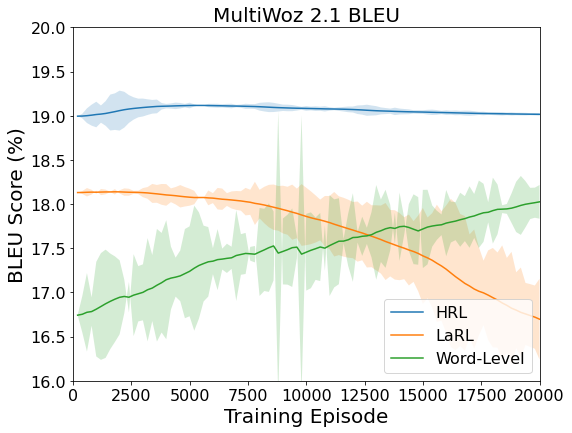

In [69]:
# plot Success
file_name = "multiwoz_%s-success"%exp_name
ax_name = "MultiWoz %s Success"%exp_name
yname = 'Success Rate (%)'
y_min, y_max = 55,85
x_min, x_max = 0, x_all[0][-1]
weight = 0.95
variance = 0.25
alpha = 0.2
y_all = success_all

# plot Match
file_name = "multiwoz_%s-inform"%exp_name
ax_name = "MultiWoz %s Inform"%exp_name
yname = 'Inform Rate (%)'
y_min, y_max = 65, 95
x_min, x_max = 0, x_all[0][-1]
weight = 0.95
variance = 0.25
alpha = 0.2
y_all = match_all


# plot BLEU
file_name = "multiwoz_%s-bleu"%exp_name
ax_name = "MultiWoz %s BLEU"%exp_name
yname = 'BLEU Score (%)'
y_min, y_max = 16, 20
x_min, x_max = 0, x_all[0][-1]
weight = 0.99
variance = 0.2
alpha = 0.2
y_all = bleu_all

# # plot Combined
# ax_name = "MultiWoz %s Combined Score"%exp_name
# yname = 'Combined Score'
# y_min, y_max = 85, 110
# x_min, x_max = 0, x_all[0][-1]
# weight = 0.9
# variance = 0.25
# alpha = 0.2

# smooth function for plots
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig.subplots_adjust(left=0.14, bottom=0.132, top=0.95, right=0.95)

ax1.set_title(ax_name, fontsize=20)
ax1.set_xlabel(xname, fontsize=20)
ax1.set_ylabel(yname, fontsize=20)
ax1.set_ylim((y_min, y_max))
ax1.set_xlim((x_min, x_max))
ax1.tick_params(labelsize=16)


for x, y, label in zip(x_all, y_all, labels):  
    ys = smooth(y, weight)
    if label == "Human":
#         ax1.plot(x, ys, label=label, linewidth=1.5, linestyle="--")
        pass
    else:
        ax1.plot(x, ys, label=label, linewidth=1.5)
    e = (ys - y)*variance
    ax1.fill_between(x, ys-e, ys+e, alpha=alpha)


# for x, s, m, b, label in zip(x_all, success_all, match_all, bleu_all, labels):  
#     y = ( s + m )* 0.5 + b
#     ys = smooth(y, weight)
#     if label == "Human":
#         ax1.plot(x, ys, label=label, linewidth=1.5, linestyle="--")
#     else:
#         ax1.plot(x, ys, label=label, linewidth=1.5)
#     e = (ys - y)*variance
#     ax1.fill_between(x, ys-e, ys+e, alpha=alpha)


ax1.legend(fontsize=16, loc='lower right')

plt.savefig(BASE_DIR + 'outputs/%s.pdf'%file_name, dpi=600)
            
            

# Plot dynamics

In [162]:
def normalize(values, index=0):
    # taks reciprocal
    if index==0:
        assert 0 not in values, '0 in values'
        return 1./ values
    # [0,1] all
    elif index==1:
        return (values-np.min(values))/(np.max(values)-np.min(values))
    elif index==2:
        norm_v = []
        for v in values:
            a = (v-np.min(v)) / (np.max(v)-np.min(v))
            norm_v.append(v)
        return np.stack(norm_v)
    else:
        return values

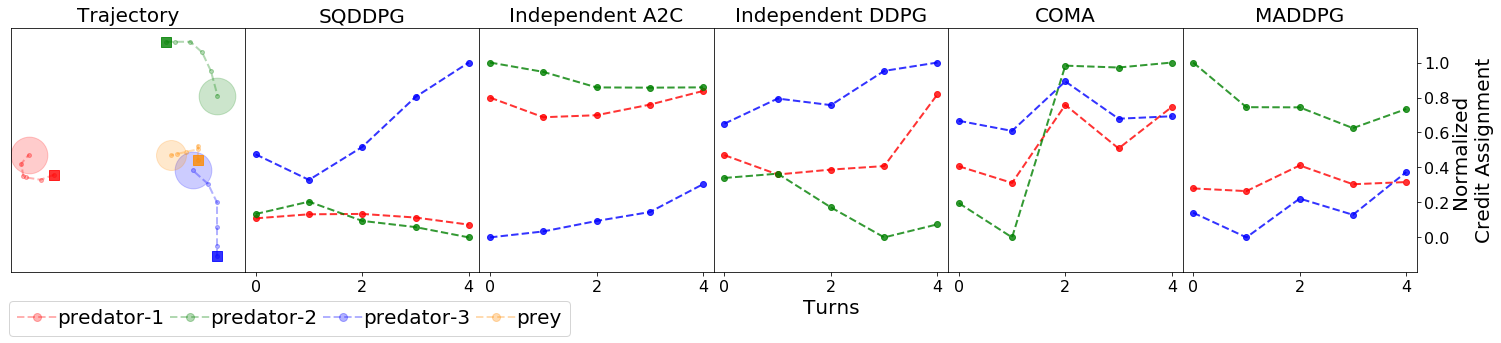

In [166]:
ep = 0

BASE_DIR = './tools/MARL/shapley-q-value-data/simple_tag/dynamics/'
DATA_DIR = BASE_DIR + 'data/episode_%s/'%str(ep)

# load data
pos = np.load(DATA_DIR+'position.npy')
sqddpg = np.load(DATA_DIR+'sqddpg_value.npy')
maddpg = np.load(DATA_DIR+'maddpg_value.npy')
coma = np.load(DATA_DIR+'coma_value.npy')
iddpg = np.load(DATA_DIR+'iddpg_value.npy')
iac = np.load(DATA_DIR+'iac_value.npy')
values = [sqddpg, iac, iddpg, coma, maddpg]

dynamics_label = ['SQDDPG', 'Independent A2C','Independent DDPG', 'COMA', 'MADDPG', ]
colors = ['r', 'g', 'b', 'darkorange']
sizes = [3,3,3,2]
sizes = [i*450 for i in sizes]
label = ['predator-1','predator-2','predator-3','prey']


# create figure
fig,axes=plt.subplots(1,6, figsize=(21,5))
fig.subplots_adjust(left=0.01, bottom=0.2, top=0.88, right=0.94,hspace=0, wspace=0)

# plot dynamics
for i in range(pos.shape[1]):
    X = pos[:,i,0]
    Y = pos[:,i,1]
    axes[0].plot(X, Y, colors[i], linestyle='dashed', linewidth=2, markersize=4, marker='o',alpha=0.3, label=label[i])
    axes[0].scatter(X[0], Y[0], s=100, c=colors[i], alpha=0.8, marker='s')
    axes[0].scatter(X[-1], Y[-1], s=sizes[i], c=colors[i], alpha=0.2, marker='o')
    axes[0].set_title('Trajectory',fontsize=20)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
axes[0].legend(loc='lower left', bbox_to_anchor=(-0.05,-0.3), ncol=4, 
               fontsize=20,markerscale=2, columnspacing=0.3, handletextpad=0.0, handlelength=2.0)

# plot values of model i
for i, value in enumerate(values):
    ax = axes[i+1]
    X = np.arange(0, value.shape[0], 1)
    value = normalize(value,1)
    for j in range(3):
        Y = value[:,j]
        ax.plot(X, Y, colors[j], linestyle='dashed', linewidth=2, markersize=6, marker='o',alpha=0.8)
    ax.set_title(dynamics_label[i], fontsize=20)
    ax.set_yticks([])
    ax.set_ylim((-0.2, 1.2))
    ax.tick_params(labelsize=16)
    if i==2:
        ax.set_xlabel('Turns', fontsize=20)

# adjust figure
axes[-1].set_yticks(np.arange(-0.0,1.2,0.2))
axes[-1].tick_params(labelsize=16)
axes[-1].set_ylabel('Normalized \nCredit Assignment', fontsize=20)
axes[-1].yaxis.set_label_position("right")
axes[-1].yaxis.tick_right()


plt.savefig(BASE_DIR+ "dynamics_%s.pdf"%ep, dpi=600)


# Calculate correlations

In [172]:
eps = 1000
BASE_DIR = './tools/MARL/shapley-q-value-data/simple_tag/dynamics/'

d_all = []
v_all = {'sqddpg':[], 'maddpg':[], 'coma':[], 'iddpg':[], 'iac':[]}

# seed = 754
# np.random.seed(seed)

for i in range(eps):
    
    ep = np.random.randint(0,1000)

    DATA_DIR = BASE_DIR + 'data/episode_%s/'%str(ep)
    
    # load values
    sqddpg = np.load(DATA_DIR+'sqddpg_value.npy') # (n, 3)
    maddpg = np.load(DATA_DIR+'maddpg_value.npy') # (n, 3)
    coma = np.load(DATA_DIR+'coma_value.npy') # (n, 3)
    iddpg = np.load(DATA_DIR+'iddpg_value.npy') # (n, 3)
    iac = np.load(DATA_DIR+'iac_value.npy') # (n, 3)
    values = [sqddpg, maddpg, coma, iddpg, iac]

    # normalize values
    i=0
    for key in v_all.keys():
        value = normalize(values[i][-1:,:],4)
        v_all[key].append(value) # (1,3)
        i+=1
    
    # load positions
    pos = np.load(DATA_DIR+'position.npy') # (n+1, 4, 2)
    distance = np.zeros((pos.shape[0],3),dtype=np.float32)
    for i in range(3):
        X = pos[:,i,0]-pos[:,-1,0]
        Y = pos[:,i,1]-pos[:,-1,1]
        d = np.sqrt(X**2 + Y**2)
        distance[:,i] = d
    d = normalize(distance[-1,:],0)
    d_all.append(d) # (1,3)
#         d_all.append(dd[-2:-1,:])

# calculate correlations
from scipy.stats import pearsonr, spearmanr
d_all = np.stack(d_all)

for key in v_all.keys():
    d = d_all.reshape(-1)
    v = np.stack(v_all[key]).reshape(-1)
    print(key, pearsonr(v,d))


sqddpg (0.28302189997105637, 2.2710197667639726e-56)
maddpg (0.04314436894462636, 0.018116423767820165)
coma (0.1331180714023496, 2.4660674544401857e-13)
iddpg (0.05316531661686495, 0.0035816857679176937)
iac (0.08117821650113163, 8.51496327645016e-06)


# Run Tester

In [263]:
# Tester

import numpy as np
import torch
from utilities.util import *
import time
import signal
import sys



class Tester(object):

    def __init__(self, env, args, sqddpg, maddpg, coma, iddpg, iac):
        self.env = env
        self.sqddpg = sqddpg.eval()
        self.coma = coma.eval()
        self.maddpg = maddpg.eval()
        self.iddpg = iddpg.eval()
        self.iac = iac.eval()
        self.args = args
        self.cuda_ = self.args.cuda
    
    def run_game(self, episodes):
        
        action = cuda_wrapper(torch.zeros((1, self.args.agent_num, self.args.action_dim)), cuda=self.cuda_)
        info = {}

        last_hidden = None
        schedule = None
        self.all_reward = []
        self.all_turn = []
        self.all_success = [] # special for traffic junction

        for ep in range(episodes):
            position = []
            sqddpg_values = []
            maddpg_values = []
            coma_values = []
            iddpg_values = []
            iac_values = []
            print ('The episode {} starts!'.format(ep))
            episode_reward = []
            state = self.env.reset()
            t = 0
            while True:
                pos = []
                for agent in self.env.world.agents:
                    pos.append(agent.state.p_pos)
                pos = np.stack(pos)
                position.append(pos)
                
                state_  = cuda_wrapper(prep_obs(state).contiguous().view(1, self.args.agent_num, self.args.obs_size), cuda=self.cuda_)
#                 state_ = state_.cpu() # TODO
                action_out = self.sqddpg.policy(state_)
                action = select_action(self.args, action_out, status='test')
                _, actual = translate_action(self.args, action, self.env)
                next_state, reward, done, debug = self.env.step(actual)
                action_ = action
#                 action_ = action.cpu() # TODO
            

                sqddpg_value = np.sum(self.sqddpg.marginal_contribution(state_, action_).detach().cpu().numpy(), axis=-1)[0,0]
                maddpg_value = np.sum(self.maddpg.value(state_, action_).detach().cpu().numpy(), axis=-1)[0]
                coma_value = np.sum(self.coma.value(state_, action_).detach().cpu().numpy() * action_.cpu().numpy(), axis=-1)[0]
                iddpg_value = np.sum(self.iddpg.value(state_, action_).detach().cpu().numpy(), axis=-1)[0]
                iac_value = np.sum(self.iac.value(state_, action_).detach().cpu().numpy() * action_.cpu().numpy(), axis=-1)[0]
                
                sqddpg_values.append(sqddpg_value)
                maddpg_values.append(maddpg_value)
                coma_values.append(coma_value)     
                iddpg_values.append(iddpg_value)
                iac_values.append(iac_value)
                
#                 print(iddpg_value, iac_value)
                
                value = []
                episode_reward.append(np.mean(reward))

                if np.all(done) or t==self.args.max_steps-1:
                    print ('The episode {} is finished!'.format(ep))
                    self.all_reward.append(np.mean(episode_reward))
                    self.all_turn.append(t+1)
                    pos = []
                    for agent in self.env.world.agents:
                        pos.append(agent.state.p_pos)
                    pos = np.stack(pos)
                    position.append(pos)
                    break
                t += 1
                state = next_state
                
            self.positions = np.stack(position)
            self.sqddpg_values = np.stack(sqddpg_values)
            self.maddpg_values = np.stack(maddpg_values)
            self.coma_values = np.stack(coma_values)
            self.iddpg_values = np.stack(iddpg_values)
            self.iac_values = np.stack(iac_values)
#             self.save(ep)
                
    def print_info(self):
        episodes = len(self.all_reward)
        print("\n"+"="*10+ " REUSLTS "+ "="*10)
        print ('Episode: {:4d}'.format(episodes))
        print('Mean Reward: {:2.4f}/{:2.4f}'.format(np.mean(self.all_reward),np.std(self.all_reward)))
        print('Mean Turn: {:2.4f}/{:2.4f}'.format(np.mean(self.all_turn),np.std(self.all_turn)))


    def save(self,ep):
        base_dir = save_path + 'dynamics/episode_%s/'%ep
        os.mkdir(base_dir)
        np.save(base_dir + "position", self.positions)
        np.save(base_dir + "sqddpg_value", self.sqddpg_values)
        np.save(base_dir + "maddpg_value", self.maddpg_values)
        np.save(base_dir + "coma_value", self.coma_values)
        np.save(base_dir + "iddpg_value", self.iddpg_values)
        np.save(base_dir + "iac_value", self.iac_values)

In [ ]:
# load models

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="1"
sys.path.append('./tools/MARL/multi-agent-rl')

save_path = 'tools/MARL/shapley-q-value-data/simple_tag/model_save/'
from utilities.tester import *


from args.simple_tag_independent_ddpg import *
model = Model[model_name]
PATH = save_path + 'simple_tag_independent_ddpg/model.pt'
target= model(args)
iddpg = model(args,target)
checkpoint = torch.load(PATH, map_location='cpu') if not args.cuda else torch.load(PATH)
iddpg.load_state_dict(checkpoint['model_state_dict'])
iddpg = iddpg.cuda()
# print(iddpg)

from args.simple_tag_independent_ac import *
model = Model[model_name]
PATH = save_path + 'simple_tag_independent_ac/model.pt'
target= model(args)
iac = model(args,target)
checkpoint = torch.load(PATH, map_location='cpu') if not args.cuda else torch.load(PATH)
iac.load_state_dict(checkpoint['model_state_dict'])
iac = iac.cuda()
# print(iac)


from args.simple_tag_maddpg import *
model = Model[model_name]
PATH = save_path + 'simple_tag_maddpg/model.pt'
target= model(args)
maddpg = model(args,target)
checkpoint = torch.load(PATH, map_location='cpu') if not args.cuda else torch.load(PATH)
maddpg.load_state_dict(checkpoint['model_state_dict'])
maddpg = maddpg.cuda()
# print(maddpg)

from args.simple_tag_coma_fc import *
model = Model[model_name]
PATH = save_path + 'simple_tag_coma/model.pt'
target = model(args)
coma = model(args,target)
checkpoint = torch.load(PATH, map_location='cpu')  if not args.cuda else torch.load(PATH)
coma.load_state_dict(checkpoint['model_state_dict'])
coma = coma.cuda()
# print(coma)


from args.simple_tag_sqddpg_old import *
model = Model[model_name]
PATH = save_path + 'simple_tag_sqddpg/model.pt'
target = model(args)
sqddpg = model(args,target)
checkpoint = torch.load(PATH, map_location='cpu') if not args.cuda else torch.load(PATH)
sqddpg.load_state_dict(checkpoint['model_state_dict'])
sqddpg = sqddpg.cuda()
# print(sqddpg)


In [ ]:
# run 1000 episodes

episodes = 1000

test = Tester(env(), args, sqddpg, maddpg, coma, iddpg, iac)
test.run_game(episodes=episodes)
test.print_info()

# eps = [0, 6, 11, 17, 19, 26, 32, 38, 43, 45, 59, 70, 78, 80, 81, 97, 98, 104, 115, 123, 126, 131, 135, 136,148]

In [6]:
import torch

a = torch.randn((3,10))
a


tensor([[ 0.9704,  0.7461, -0.1436, -0.9657,  0.6581,  1.7610, -0.6204,  0.5340,
         -0.8734, -0.8645],
        [-0.8816,  0.0494, -0.7635, -1.3153,  0.2908,  0.1693,  0.1671,  1.0775,
          0.8338,  0.3143],
        [ 0.4008,  0.3996,  0.5557, -0.1162,  0.6928, -0.0914,  1.6761,  0.1839,
         -1.1959, -2.2296]])

In [11]:
b = torch.cat([a]*2, dim=-1).view(-1, 10)
b

tensor([[ 0.9704,  0.7461, -0.1436, -0.9657,  0.6581,  1.7610, -0.6204,  0.5340,
         -0.8734, -0.8645],
        [ 0.9704,  0.7461, -0.1436, -0.9657,  0.6581,  1.7610, -0.6204,  0.5340,
         -0.8734, -0.8645],
        [-0.8816,  0.0494, -0.7635, -1.3153,  0.2908,  0.1693,  0.1671,  1.0775,
          0.8338,  0.3143],
        [-0.8816,  0.0494, -0.7635, -1.3153,  0.2908,  0.1693,  0.1671,  1.0775,
          0.8338,  0.3143],
        [ 0.4008,  0.3996,  0.5557, -0.1162,  0.6928, -0.0914,  1.6761,  0.1839,
         -1.1959, -2.2296],
        [ 0.4008,  0.3996,  0.5557, -0.1162,  0.6928, -0.0914,  1.6761,  0.1839,
         -1.1959, -2.2296]])